**1. Importing Libraries.**

In [1]:
import numpy as np
import pandas as pd
import librosa
import glob
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense , LSTM , Dropout , Softmax , LayerNormalization , Conv2D , MaxPool2D , Flatten , BatchNormalization
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt

**2. Analyzing the mean length of audio files in the data.**

In [7]:
def mean_audio_length():
    """
    This function finds the mean length of all the audios.
    """
    # Creating an empty list to store the lengths of each audio file
    audio_length = []
    
    # Creating a list of class names
    classes = ['Aditya_english','Aditya_hindi' ,'Viashali_english','Viashali_hindi', 'Preeti_english','Preeti_hindi', 'Alice_english','Alice_hindi' , 'Srinath_english','Srinath_hindi']
    
    # Iterating over each class
    for i in classes:
        # Creating a file path string that includes the class name
        audio_path = '/content/drive/MyDrive/EXPERIMENT 4 (MINI)/' + str(i) + '/*'
      
        
        # Using glob to find all audio files that match the file path pattern
        audio_files = glob.glob(audio_path)
    
        
        # Iterating over each audio file in the list of matching files
        for j in range(len(audio_files)):
            # Loading the audio file into a NumPy array using librosa
            audio , sr = librosa.load(audio_files[j])
            
            # Appending the length of the audio file to the list of audio lengths
            audio_length.append(len(audio))
            # print(audio_length)
            
            # Optional: Printing the length of each audio file as it's processed
            # print(len(audio))
    
    # Calculate the mean length of" all audio files in the list
    return np.mean(audio_length)

In [8]:
mean_length = mean_audio_length()
print("Mean length of all the collected audios is :", mean_length)

Mean length of all the collected audios is : 45880.04


**3. Preparing the Training and Testing Data for the KNN Model.**

In [9]:
def audio_data_knn(mean_length):
  # Create empty dictionaries to store the training and testing data
  data_train = {'labels':[],
                'mfcc':[]}
  data_test = {'labels':[],
                'mfcc':[]}
  
  # Define a list of class names
  classes = ['Aditya_english','Aditya_hindi' ,'Viashali_english','Viashali_hindi', 'Preeti_english','Preeti_hindi', 'Alice_english','Alice_hindi' , 'Srinath_english','Srinath_hindi']
  
  # Loop over each class
  for i in classes:
      # Set the path to the directory containing the audio files for this class
      audio_path = '/content/drive/MyDrive/EXPERIMENT 4 (MINI)/' + str(i) + '/*'
      # Use the glob function to get a list of audio files in the directory
      audio_files = glob.glob(audio_path)
      # Loop over all audio files except the last one (used for testing)
      for j in range(len(audio_files)-2):
        # Load the audio file using librosa
        audio,sr = librosa.load(audio_files[j])
        # If the audio file is longer than the mean length, truncate it
        if len(audio)>mean_length:
          audio = audio[0:int(mean_length)]
        # If the audio file is shorter than the mean length, pad it with zeros
        if len(audio)<mean_length:
          diff = int(mean_length) - len(audio)
          audio = np.pad(audio,(0,diff))
        # Compute the MFCC features for the audio file
        mfcc = librosa.feature.mfcc(y=audio,sr=sr,n_mfcc=8)
        # Add the MFCC features and label to the training data dictionary
        data_train['mfcc'].append(mfcc.flatten())
        data_train['labels'].append(i)
      # Load the last 2 audio file in the directory (used for testing)
      for k in range(len(audio_files)-1,len(audio_files)):
        audio,sr = librosa.load(audio_files[k])
        # If the audio file is longer than the mean length, truncate it
        if len(audio)>mean_length:
          audio = audio[0:int(mean_length)]
        # If the audio file is shorter than the mean length, pad it with zeros
        if len(audio)<mean_length:
          diff = int(mean_length) - len(audio)
          audio = np.pad(audio,(0,diff))
        # Compute the MFCC features for the audio file
        mfcc = librosa.feature.mfcc(y=audio,sr=sr,n_mfcc = 8)
        # Add the MFCC features and label to the testing data dictionary
        data_test['mfcc'].append(mfcc.flatten())
        data_test['labels'].append(i)
  # Return the training and testing data dictionaries
  return data_train,data_test

In [10]:
# Call the audio_data_knn function with the mean_length argument to get the training and testing data.
knn_train_data , knn_test_data = audio_data_knn(mean_length)

In [11]:
X_knn_train = knn_train_data['mfcc']
X_knn_test = knn_test_data['mfcc']
y_knn_train = knn_train_data['labels']
y_knn_test = knn_test_data['labels']

In [12]:
# Ensuring that all sequences in the dataset have the same length
X_knn_train = tf.keras.preprocessing.sequence.pad_sequences(X_knn_train)
X_knn_test = tf.keras.preprocessing.sequence.pad_sequences(X_knn_test)

In [13]:
X_knn_train.shape

(130, 720)

In [15]:
mapping = {'Aditya_english' : 0,'Aditya_hindi' : 1,'Viashali_english': 2,'Viashali_hindi': 3, 'Preeti_english': 4,'Preeti_hindi': 5, 'Alice_english' : 6,'Alice_hindi' : 7 , 'Srinath_english' : 8,'Srinath_hindi' : 9}

# convert y_knn_train to a Pandas DataFrame and assign it to y_knn_train
y_knn_train = pd.DataFrame(y_knn_train)

# replace the values in y_knn_train using the provided mapping dictionary and assign it to y_knn_train
y_knn_train = y_knn_train.replace(mapping)

# convert y_knn_train to a numpy array and assign it back to y_knn_train
y_knn_train = np.array(y_knn_train)

# convert y_knn_test to a Pandas DataFrame and assign it to y_knn_test
y_knn_test = pd.DataFrame(y_knn_test)

# replace the values in y_knn_test using the provided mapping dictionary and assign it to y_knn_test
y_knn_test = y_knn_test.replace(mapping)

# convert y_knn_test to a numpy array and assign it back to y_knn_test
y_knn_test = np.array(y_knn_test)

Average accuracy: 0.48333333333333334


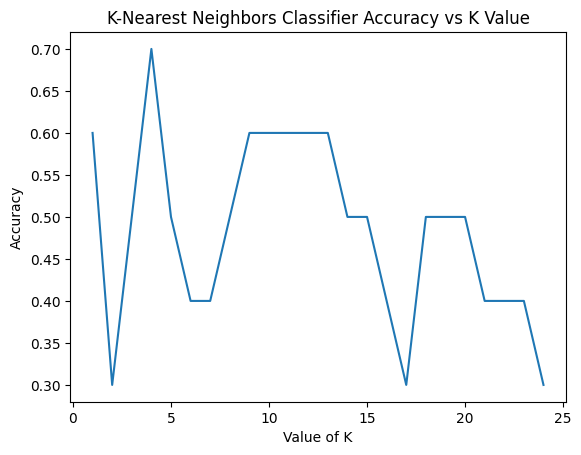

In [18]:
k_values = []
accuracies = []

for i in range(1, 25):
    # create a KNeighborsClassifier object with i neighbors and assign it to knn_classifier
    knn_classifier = KNeighborsClassifier(n_neighbors=i)

    # fit the knn_classifier on the training data X_knn_train and y_knn_train
    knn_classifier.fit(X_knn_train, y_knn_train.reshape(-1))

    # calculate the accuracy of the knn_classifier on the test data
    accuracy = knn_classifier.score(X_knn_test, y_knn_test)

    # add the k value and accuracy to the corresponding lists
    k_values.append(i)
    accuracies.append(accuracy)

# print the average accuracy
print('Average accuracy:', np.mean(accuracies))

# create a line plot of the accuracies vs the k values
plt.plot(k_values, accuracies)
plt.xlabel('Value of K')
plt.ylabel('Accuracy')
plt.title('K-Nearest Neighbors Classifier Accuracy vs K Value')
plt.show()

In [19]:
knn_classifier = KNeighborsClassifier(n_neighbors=4)
knn_classifier.fit(X_knn_train, y_knn_train.reshape(-1))
print("The Best Accuracy of K-Nearest Neighbour model :" , knn_classifier.score(X_knn_test,y_knn_test) * 100 ,"%")

The Best Accuracy of K-Nearest Neighbour model : 70.0 %


**3. Preparing the Training and Testing Data for the CNN Model.**

In [20]:
def audio_data(mean_length):

  """
  This function takes the mean audio length of all data and returns the train and test data. 

  """
  
  # Creating two empty dictionaries for training and testing data with 'labels' and 'mfcc' keys
  data_train = {'labels':[],'mfcc':[]}
  data_test = {'labels':[],'mfcc':[]}
  
  # Defining a list of class names
  classes = ['Aditya_english','Aditya_hindi' ,'Viashali_english','Viashali_hindi', 'Preeti_english','Preeti_hindi', 'Alice_english','Alice_hindi' , 'Srinath_english','Srinath_hindi']
  
  # Looping through each class
  for i in classes:
    
    # Creating a string of file paths for each class
    audio_path = '/content/drive/MyDrive/EXPERIMENT 4 (MINI)/' + str(i) + '/*'
    
    # Getting a list of all audio files in the directory
    audio_files = glob.glob(audio_path)
    
    # Looping through each audio file except for the last one (which will be used for testing)
    for j in range(len(audio_files)-2):
      
      # Loading the audio file using librosa library and its corresponding sample rate
      audio,sr = librosa.load(audio_files[j])
      
      # If the audio is longer than the mean_length, then trimming it
      if len(audio)>mean_length:
        audio = audio[0:int(mean_length)]
        
      # If the audio is shorter than the mean_length, then padding it with zeros
      if len(audio)<mean_length:
        diff = int(mean_length) - len(audio)
        audio = np.pad(audio,(0,diff))
      
      # Computing the MFCC features of the audio signal
      mfcc = librosa.feature.mfcc(y=audio,sr=sr)
      
      # Appending the MFCC features and the corresponding label to the training data dictionary
      data_train['mfcc'].append(mfcc.T)
      data_train['labels'].append(i)
      
    # Loading the last audio file in the directory for testing
    for k in range(len(audio_files)-2,len(audio_files)):
      
      # Loading the audio file using librosa library and its corresponding sample rate
      audio,sr = librosa.load(audio_files[k])
      
      # If the audio is longer than the mean_length, then trimming it
      if len(audio)>mean_length:
        audio = audio[0:int(mean_length)]
        
      # If the audio is shorter than the mean_length, then padding it with zeros
      if len(audio)<mean_length:
        diff = int(mean_length) - len(audio)
        audio = np.pad(audio,(0,diff))
      
      # Computing the MFCC features of the audio signal
      mfcc = librosa.feature.mfcc(y=audio,sr=sr)
      
      # Appending the MFCC features and the corresponding label to the testing data dictionary
      data_test['mfcc'].append(mfcc.T)
      data_test['labels'].append(i)
  
  # Returning the training and testing data dictionaries
  return data_train, data_test

In [21]:
# Storing the obtained train and test data.
train_data , test_data = audio_data(mean_length)

X_train = train_data['mfcc']
y_train = train_data['labels']
X_test = test_data['mfcc']
y_test = test_data['labels']

In [22]:
# Ensuring that all sequences in the dataset have the same length
# Padding the sequences in X_train to a maximum length of 44
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train, maxlen=44)

# Padding the sequences in X_test to a maximum length of 44
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, maxlen=44)

In [23]:
X_train.shape

(130, 44, 20)

In [24]:
# preprocessing step where categorical labels are mapped to numerical values, so that they can be used as inputs to the model.
mapping = {'Aditya_english' : 0,'Aditya_hindi' : 1,'Viashali_english': 2,'Viashali_hindi': 3, 'Preeti_english': 4,'Preeti_hindi': 5, 'Alice_english' : 6,'Alice_hindi' : 7 , 'Srinath_english' : 8,'Srinath_hindi' : 9}
   # creating a dictionary that maps class names to integers

y_train = pd.DataFrame(y_train)    # converting y_train to a pandas dataframe
y_train = y_train.replace(mapping)    # replacing the class names in y_train with their integer mappings
y_train = np.array(y_train)    # converting y_train to a numpy array

y_test = pd.DataFrame(y_test)    # converting y_test to a pandas dataframe
y_test = y_test.replace(mapping)    # replacing the class names in y_test with their integer mappings
y_test = np.array(y_test)    # converting y_test to a numpy array

In [ ]:
# print("y_train :",y_train)
# print("Shape of X_train :",X_train.shape)
# print("Shape of sample data :",X_train[0].shape)

**4. Building a Convolutional Neural Network model.**

In [28]:
def build_model(input_shape):
    """
    Builds a Convolutional Neural Network model using TensorFlow and Keras.

    Args:
        input_shape: A tuple of integers representing the shape of the input data.

    Returns:
        model: A compiled CNN model using the input shape.
    """

    # Creating a Sequential model
    model = tf.keras.Sequential()

    # Adding Conv2D layer with 8 filters and kernel size of (2,2) with relu activation function
    # and the input shape
    model.add(Conv2D(8, kernel_size=(2, 2), activation='relu', input_shape=input_shape))

    # Adding MaxPooling2D layer
    model.add(MaxPool2D())

    # Adding BatchNormalization layer
    model.add(BatchNormalization())

    # Adding Conv2D layer with 4 filters and kernel size of (2,2) with relu activation function
    model.add(Conv2D(4, kernel_size=(2, 2), activation='relu'))

    # Adding MaxPooling2D layer
    model.add(MaxPool2D())

    # Adding Flatten layer
    model.add(Flatten())

    # Adding Dense layer with 5 output units
    model.add(Dense(10))

    # Adding Softmax activation function to the last Dense layer
    model.add(Softmax(axis=1))

    # Compiling the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [47]:
# Reshaping the training audio data to have 4 dimensions: batch size, audio samples, audio channels, and time steps
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)

# Getting the shape of the first audio clip in the training data
input_shape = X_train[0].shape

# Reshaping the testing audio data to have 4 dimensions: batch size, audio samples, audio channels, and time steps
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)

# Building the CNN model using the input shape
model = build_model(input_shape)

# Defining the Adam optimizer with a learning rate of 0.001
opt = tf.keras.optimizers.Adam(learning_rate = 0.003)

# Compiling the model with the Adam optimizer, sparse categorical crossentropy loss function, and accuracy metric
model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Training the model on the training data using a batch size of 2, 50 epochs, and shuffling the data before each epoch
history = model.fit(X_train, y_train, batch_size= 10 , epochs = 40 , shuffle = True)

Epoch 1/40
13/13 [==============================] - 1s 9ms/step - loss: 2.4964 - accuracy: 0.0846
Epoch 2/40
13/13 [==============================] - 0s 10ms/step - loss: 2.1742 - accuracy: 0.1923
Epoch 3/40
13/13 [==============================] - 0s 10ms/step - loss: 2.0179 - accuracy: 0.3231
Epoch 4/40
13/13 [==============================] - 0s 9ms/step - loss: 1.8231 - accuracy: 0.4077
Epoch 5/40
13/13 [==============================] - 0s 9ms/step - loss: 1.6203 - accuracy: 0.4846
Epoch 6/40
13/13 [==============================] - 0s 9ms/step - loss: 1.4090 - accuracy: 0.5538
Epoch 7/40
13/13 [==============================] - 0s 9ms/step - loss: 1.2301 - accuracy: 0.6385
Epoch 8/40
13/13 [==============================] - 0s 10ms/step - loss: 1.0814 - accuracy: 0.6462
Epoch 9/40
13/13 [==============================] - 0s 10ms/step - loss: 0.9434 - accuracy: 0.7000
Epoch 10/40
13/13 [==============================] - 0s 9ms/step - loss: 0.7868 - accuracy: 0.7769
Epoch 11/40
13/

In [48]:
# Evaluating the trained model on the testing data and get the test loss and test accuracy
test_loss, test_acc = model.evaluate(X_test, y_test)

1/1 [==============================] - 0s 160ms/step - loss: 1.8746 - accuracy: 0.4000


In [50]:
print("The Accuracy of Convolutional Neural Network model : ", test_acc * 100 , "%") 

The Accuracy of Convolutional Neural Network model :  40.00000059604645 %


**5. Building a LSTM Model.**

In [52]:
def bulid_model2(input_shape):
  """
  This function defines and returns a Sequential model for training and testing on a given dataset.
  It uses two LSTM layers with dropout and layer normalization, followed by two Dense layers and a Softmax output layer.

  Args:
  input_shape: A tuple representing the shape of the input data. It should have the format (timesteps, features).

  Returns:
  A Keras Sequential model with the specified architecture.

  """
  
  # Defining the Sequential model
  model = tf.keras.Sequential()
  
  # Adding the first LSTM layer with 128 units, input shape, and return sequences
  model.add(LSTM(128,input_shape = input_shape,return_sequences=True))
  
  # Adding a Dropout layer with a rate of 0.4
  model.add(Dropout(0.4))
  
  # Adding a LayerNormalization layer
  model.add(LayerNormalization())
  
  # Adding the second LSTM layer with 64 units
  model.add(LSTM(64))
  
  # Adding a Dense layer with 32 units
  model.add(Dense(32))
  
  # Adding a second Dense layer with 2 units for the output
  model.add(Dense(10))
  
  # Adding a Softmax activation function to the output layer
  model.add(Softmax(axis=1))
  
  # Returning the completed model
  return model

In [53]:
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,maxlen=258)
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,maxlen=258)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [54]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2])
input_shape = X_train[0].shape
# Definng the model architecture using the `bulid_model2` function with the given input shape
model2 = bulid_model2(input_shape)

# Defining the Adam optimizer with a learning rate of 0.001
opt = tf.keras.optimizers.Adam(learning_rate=0.001)

# Compiling the model with the specified optimizer, loss function, and metrics
model2.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Training the model on the training data (`X_train` and `y_train`) for 50 epochs, using a batch size of 8
history = model2.fit(X_train, y_train, batch_size = 5 , epochs = 20)

# The `fit` method performs backpropagation to update the model parameters (weights and biases) based on the training data
# The loss and accuracy metrics for each epoch are recorded in the `history` object

Epoch 1/20
26/26 [==============================] - 10s 251ms/step - loss: 2.2254 - accuracy: 0.1385
Epoch 2/20
26/26 [==============================] - 7s 255ms/step - loss: 1.7568 - accuracy: 0.3692
Epoch 3/20
26/26 [==============================] - 6s 226ms/step - loss: 1.3959 - accuracy: 0.5385
Epoch 4/20
26/26 [==============================] - 8s 292ms/step - loss: 1.0708 - accuracy: 0.6615
Epoch 5/20
26/26 [==============================] - 6s 224ms/step - loss: 0.9904 - accuracy: 0.6692
Epoch 6/20
26/26 [==============================] - 7s 284ms/step - loss: 0.9463 - accuracy: 0.6615
Epoch 7/20
26/26 [==============================] - 6s 225ms/step - loss: 0.8510 - accuracy: 0.7538
Epoch 8/20
26/26 [==============================] - 7s 283ms/step - loss: 0.7000 - accuracy: 0.7769
Epoch 9/20
26/26 [==============================] - 6s 224ms/step - loss: 0.5704 - accuracy: 0.8000
Epoch 10/20
26/26 [==============================] - 8s 299ms/step - loss: 0.5467 - accuracy: 0.784

In [55]:
# Evaluating the trained model on the testing data and get the test loss and test accuracy
test_loss, test_acc = model2.evaluate(X_test, y_test)

1/1 [==============================] - 2s 2s/step - loss: 1.0737 - accuracy: 0.7000


In [56]:
print("The Accuracy of LSTM model : ", test_acc * 100 , '%')

The Accuracy of LSTM model :  69.9999988079071 %
